In [1]:
import pandas as pd
import numpy as np
import os
import quandl
from datetime import datetime
import backtrader as bt
import backtrader.feeds as btfeeds
import matplotlib.pyplot as plt

quandl.ApiConfig.api_key = os.getenv('QUANDL_APY_KEY')

In [2]:
def get_data(ticker, start_date, end_date):
    columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    result = quandl.get_table('SHARADAR/SEP', ticker=ticker, qopts={"columns":columns}, 
                          date={'gte': start_date, 'lte': end_date})
    result.set_index('date', inplace=True)
    result.sort_index(inplace=True)

    df_pe = quandl.get_table('SHARADAR/DAILY', ticker=ticker, qopts={"columns":["date", "pe"]}, 
                              date={'gte': start_date, 'lte': end_date})
    df_pe.set_index('date', inplace=True)
    df_pe.sort_index(inplace=True)

    result = pd.concat([result, df_pe], axis=1)
    return result

In [3]:
start_date = datetime(2008, 1, 1)
end_date = datetime(2009, 1, 1)

ticker1 = 'AXP'
df1 = get_data(ticker1, start_date, end_date)
print(df1.head())
print(df1.tail())

             open   high    low  close      volume    pe
date                                                    
2008-01-02  52.09  52.32  50.79  51.04   8053700.0  14.5
2008-01-03  51.22  51.50  50.20  50.41   7753200.0  14.4
2008-01-04  49.91  49.99  48.71  49.14   8501400.0  14.0
2008-01-07  49.41  50.10  48.59  49.36  14031100.0  14.1
2008-01-08  49.50  49.70  47.76  47.95  11721000.0  13.7
             open   high    low  close      volume   pe
date                                                   
2008-12-24  18.00  18.15  17.92  17.97   4189500.0  6.3
2008-12-26  18.08  18.15  17.62  17.91   4598100.0  6.3
2008-12-29  17.96  18.10  17.51  17.70   8033700.0  6.2
2008-12-30  17.82  18.13  17.70  18.00  11777300.0  6.3
2008-12-31  17.97  18.75  17.91  18.55   9625600.0  6.5


In [4]:
ticker2 = 'NKE'
df2 = get_data(ticker2, start_date, end_date)
print(df2.head())
print(df2.tail())

             open    high     low   close      volume    pe
date                                                       
2008-01-02  16.08  16.175  15.675  15.820   9781600.0  18.7
2008-01-03  15.82  15.938  15.595  15.678  10636000.0  18.6
2008-01-04  15.56  15.720  15.425  15.435  22335200.0  18.3
2008-01-07  15.50  15.580  15.325  15.527  20808400.0  18.4
2008-01-08  15.60  15.745  15.385  15.457  16714400.0  18.3
              open    high     low   close      volume    pe
date                                                        
2008-12-24  12.012  12.345  11.910  12.283   4384800.0  13.1
2008-12-26  12.325  12.505  12.325  12.440   4919200.0  13.2
2008-12-29  12.425  12.492  12.068  12.235   9346000.0  13.0
2008-12-30  12.332  12.450  12.197  12.422   9626400.0  13.2
2008-12-31  12.453  12.887  12.385  12.750  15089600.0  13.6


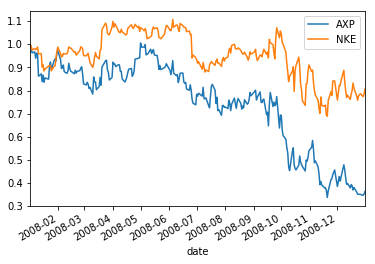

In [5]:
#
dfa = df1[['close']] / df1[['close']].iloc[0, :]
dfb = df2[['close']] / df2[['close']].iloc[0, :]
dfa.columns = [ticker1]
dfb.columns = [ticker2]
pd.concat([dfa, dfb], axis=1).plot()

In [6]:
class PandasData2(btfeeds.PandasData):
    lines = ('pe',)
    params = (('pe', -1),)

In [7]:
data = PandasData2(dataname=df1) #btfeeds.PandasData(dataname=df1) #
data2 = PandasData2(dataname=df2) #btfeeds.PandasData(dataname=df2) #

In [8]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose1 = self.datas[0].close
        self.dataclose2 = self.datas[1].close
        
        self.pe1 = self.datas[0].pe
        self.pe2 = self.datas[1].pe
        
        self.cash = 0
        
    def notify_cashvalue(self, cash, value):
        self.cash = cash

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close, {ticker2}: Price: {self.dataclose2[0]:.2f} / PE: {self.pe2[0]:.2f}')
        
        if not self.position:
            if self.pe2 < 15:
                if self.cash > self.dataclose2[0]:
                    amount = int(self.cash / self.dataclose2[0] * 0.6)
                    self.log(f'BUY CREATE, Price: {self.dataclose2[0]:.2f}, Amount: {amount} ****************************************')
                    self.buy(data=self.datas[1], size=amount)
        else:
            if self.pe2 > 25:
                self.log('SELL CREATE, %.2f ****************************************' % self.dataclose2[0])
                self.sell()

In [9]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data)
cerebro.adddata(data2)
cerebro.broker.setcash(100000.0)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2008-01-02, Close, NKE: Price: 15.82 / PE: 18.70
2008-01-03, Close, NKE: Price: 15.68 / PE: 18.60
2008-01-04, Close, NKE: Price: 15.44 / PE: 18.30
2008-01-07, Close, NKE: Price: 15.53 / PE: 18.40
2008-01-08, Close, NKE: Price: 15.46 / PE: 18.30
2008-01-09, Close, NKE: Price: 15.49 / PE: 17.90
2008-01-10, Close, NKE: Price: 15.63 / PE: 18.10
2008-01-11, Close, NKE: Price: 15.18 / PE: 17.60
2008-01-14, Close, NKE: Price: 15.18 / PE: 17.60
2008-01-15, Close, NKE: Price: 14.27 / PE: 16.50
2008-01-16, Close, NKE: Price: 14.42 / PE: 16.70
2008-01-17, Close, NKE: Price: 13.99 / PE: 16.20
2008-01-18, Close, NKE: Price: 14.12 / PE: 16.40
2008-01-22, Close, NKE: Price: 14.32 / PE: 16.60
2008-01-23, Close, NKE: Price: 14.38 / PE: 16.70
2008-01-24, Close, NKE: Price: 14.35 / PE: 16.60
2008-01-25, Close, NKE: Price: 14.00 / PE: 16.20
2008-01-28, Close, NKE: Price: 14.32 / PE: 16.60
2008-01-29, Close, NKE: Price: 14.34 / PE: 16.60
2008-01-30, Close, NKE: Price: 14

In [187]:
((1275/1431))*100000

89098.53249475891